In [19]:
# EKF Baseline - Focus on Finding Best Flights
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_root = Path.cwd()
for up in [repo_root, repo_root.parent, repo_root.parent.parent]:
    if (up / "src").exists():
        repo_root = up
        break
sys.path.insert(0, str(repo_root))

from src.ekf_model import CoordinatedTurnEKF, EKFParams, rmse_from_results

print(f"✓ Repository: {repo_root}")
print("="*60)
print("GOAL: Find the 5 best performing flights for visualization")
print("="*60)

✓ Repository: /Users/danielvillafuerte/weather-aware-trajectory-prediction
GOAL: Find the 5 best performing flights for visualization


In [20]:
# Load data
DATA_PATH = repo_root / "data" / "processed" / "flights_nativecadence_enu_kinematics.parquet"
df = pd.read_parquet(DATA_PATH)

print(f"Total data: {len(df):,} rows")
print(f"Total flight segments: {df.groupby(['flight_id', 'run_id']).ngroups}")

# Calculate flight statistics
flight_stats = df.groupby(['flight_id', 'run_id']).agg({
    'time': ['count', lambda x: (x.max() - x.min()).total_seconds()/60],
    'E': lambda x: x.max() - x.min(),
    'N': lambda x: x.max() - x.min(),
    'U': lambda x: x.max() - x.min(),
    'speed': ['mean', 'std'],
    'dt': 'median',
    'turn_rate': lambda x: x.abs().mean() if 'turn_rate' in df.columns else 0
})

flight_stats.columns = ['n_points', 'duration_min', 'E_range', 'N_range', 
                        'alt_change', 'mean_speed', 'std_speed', 'cadence', 'mean_turn']
flight_stats['distance'] = np.sqrt(flight_stats['E_range']**2 + flight_stats['N_range']**2)

# Define STRICT quality criteria for good EKF performance
quality_criteria = {
    'n_points': (150, np.inf),      # At least 150 points
    'duration_min': (15, 60),       # 15-60 minutes
    'alt_change': (0, 5000),        # Max 5km altitude change
    'distance': (30000, 800000),    # 30-800 km traveled
    'cadence': (0, 20),             # Max 20s between points
    'mean_speed': (50, 350),        # Reasonable speed range (m/s)
    'std_speed': (0, 100)           # Not too variable speed
}

# Apply all criteria
mask = pd.Series(True, index=flight_stats.index)
for col, (min_val, max_val) in quality_criteria.items():
    if col in flight_stats.columns:
        mask &= (flight_stats[col] >= min_val) & (flight_stats[col] <= max_val)
        
candidate_flights = flight_stats[mask].sort_values('n_points', ascending=False)

print(f"\nFlights meeting quality criteria: {len(candidate_flights)}")
print("\nTop 10 candidates:")
print(candidate_flights.head(10)[['n_points', 'distance', 'alt_change', 'mean_speed']])

Total data: 1,038,555 rows
Total flight segments: 5492

Flights meeting quality criteria: 84

Top 10 candidates:
                  n_points       distance   alt_change  mean_speed
flight_id run_id                                                  
4217      0            359  197889.898587  4061.403908   55.305841
3569      0            359   65399.786377   261.169916  120.490733
2704      0            348   71939.314780  1269.141621   56.433421
2519      0            322  104984.055445  2568.561110   57.719928
3269      0            321  244814.610830  4661.069967   77.890077
3951      0            314  223503.805474  3801.028888   72.962730
2677      0            292  157888.264095  1894.341974   56.441914
4189      0            287   87872.971281  1054.961188   52.312953
4397      0            286  159883.584775  4099.523161   75.553604
3976      0            270  110178.920856   884.383079   66.640269


In [21]:
def resample_track(track_df, dt_target=5.0):
    """Resample track to consistent time intervals"""
    track = track_df.copy()
    
    # Create regular time grid
    t_start = track['time'].iloc[0]
    t_end = track['time'].iloc[-1]
    t_regular = pd.date_range(start=t_start, end=t_end, freq=f'{int(dt_target)}s')
    
    # Interpolate to regular grid
    track = track.set_index('time')
    
    # Select only numeric columns for interpolation
    numeric_cols = track.select_dtypes(include=[np.number]).columns
    non_numeric_cols = track.select_dtypes(exclude=[np.number]).columns
    
    # Reindex and interpolate numeric columns
    track_regular = track.reindex(t_regular)
    track_regular[numeric_cols] = track_regular[numeric_cols].interpolate(method='linear', limit=2)
    
    # Forward fill non-numeric columns
    for col in non_numeric_cols:
        track_regular[col] = track_regular[col].fillna(method='ffill')
    
    track_regular = track_regular.dropna(subset=['E', 'N', 'U'])
    track_regular = track_regular.reset_index().rename(columns={'index': 'time'})
    
    # Recalculate dt and ensure turn_rate exists
    track_regular['dt'] = track_regular['time'].diff().dt.total_seconds()
    if 'turn_rate' not in track_regular.columns:
        track_regular['turn_rate'] = 0.0
        
    return track_regular

print("✓ Resampling function ready")

✓ Resampling function ready


In [5]:
# Test on ONE good flight first
test_flight_id, test_run_id = good_flights.index[0]

# Extract and resample
test_flight = df[(df['flight_id'] == test_flight_id) & 
                 (df['run_id'] == test_run_id)].copy()
test_flight = test_flight.sort_values('time').reset_index(drop=True)
test_flight_resampled = resample_track(test_flight, dt_target=5.0)

print(f"Testing Flight {test_flight_id}, Run {test_run_id}")
print(f"Original points: {len(test_flight)}, Resampled: {len(test_flight_resampled)}")

# Initialize EKF
ekf = CoordinatedTurnEKF(params=EKFParams(), use_wind=False)

# Filter the track
filtered = ekf.filter_track(test_flight_resampled)

# Use the PROPER horizon_errors method!
horizons = [60, 120, 300]
results = ekf.horizon_errors(test_flight_resampled, filtered, horizons)

# Calculate RMSE
rmse_values = rmse_from_results(results)
print("\nSingle Flight Results:")
for h in horizons:
    if h in rmse_values.index:
        print(f"  {h:3d}s horizon: {rmse_values[h]:7.1f} m")

/var/folders/4j/b4y6wwhd0m18s4zqjd6p25mc0000gn/T/ipykernel_24391/2919325017.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  t_regular = pd.date_range(start=t_start, end=t_end,
/var/folders/4j/b4y6wwhd0m18s4zqjd6p25mc0000gn/T/ipykernel_24391/2919325017.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  track_regular = track_regular.interpolate(method='linear', limit=2)


Testing Flight 4217, Run 0
Original points: 359, Resampled: 716

Single Flight Results:
   60s horizon:   473.7 m
  120s horizon:  1057.4 m
  300s horizon:  7994.4 m


In [22]:
# Test all candidate flights to find the best performers
ekf = CoordinatedTurnEKF(params=EKFParams(), use_wind=False)
horizons = [60, 120, 300]

flight_performance = []
n_candidates = min(50, len(candidate_flights))  # Test up to 50 flights

print(f"\nTesting {n_candidates} candidate flights...")
print("-" * 40)

for idx, (flight_id, run_id) in enumerate(candidate_flights.index[:n_candidates]):
    try:
        # Extract flight
        flight = df[(df['flight_id'] == flight_id) & (df['run_id'] == run_id)].copy()
        flight = flight.sort_values('time').reset_index(drop=True)
        
        # Resample
        flight_resampled = resample_track(flight, dt_target=5.0)
        
        if len(flight_resampled) < 100:
            continue
        
        # Run EKF
        filtered = ekf.filter_track(flight_resampled)
        
        # Calculate errors at horizons
        results = ekf.horizon_errors(flight_resampled, filtered, horizons)
        rmse = rmse_from_results(results)
        
        # Store results
        perf_record = {
            'flight_id': flight_id,
            'run_id': run_id,
            'n_points_original': len(flight),
            'n_points_resampled': len(flight_resampled),
            'rmse_60': rmse.get(60, np.nan),
            'rmse_120': rmse.get(120, np.nan),
            'rmse_300': rmse.get(300, np.nan),
            'mean_error_60': results[60]['err_m'].mean() if 60 in results else np.nan,
            'median_error_60': results[60]['err_m'].median() if 60 in results else np.nan,
            'flight_stats': candidate_flights.loc[(flight_id, run_id)].to_dict()
        }
        
        flight_performance.append(perf_record)
        
        # Progress update
        if (idx + 1) % 5 == 0:
            print(f"  Tested {idx + 1}/{n_candidates} flights...")
            
    except Exception as e:
        print(f"  Flight {flight_id} failed: {str(e)[:50]}")
        continue

# Convert to DataFrame and sort by performance
perf_df = pd.DataFrame(flight_performance).dropna(subset=['rmse_60'])
perf_df = perf_df.sort_values('rmse_60')

print(f"\nSuccessfully tested {len(perf_df)} flights")
print("\nTop 10 by 60s RMSE:")
print(perf_df[['flight_id', 'run_id', 'rmse_60', 'rmse_120', 'rmse_300']].head(10))


Testing 50 candidate flights...
----------------------------------------
  Tested 5/50 flights...
  Tested 10/50 flights...
  Tested 15/50 flights...
  Tested 20/50 flights...
  Tested 25/50 flights...
  Tested 30/50 flights...
  Tested 35/50 flights...
  Tested 40/50 flights...
  Tested 45/50 flights...
  Tested 50/50 flights...

Successfully tested 50 flights

Top 10 by 60s RMSE:
    flight_id  run_id      rmse_60      rmse_120      rmse_300
0        4217       0   222.287751    484.969722  1.812288e+03
12       5707       0   359.497001   1148.249876  6.133016e+03
18       5840       0   620.758136   1860.702771  8.202985e+03
27       6151       0   697.141731   1574.722809  5.812475e+03
23       5251       0   852.592608   2021.769626  7.931140e+03
16       3189       0   869.783444   2441.590184  9.944399e+03
33       4279       0   950.128349  18715.966223  1.129820e+10
5        3951       0   952.594403   2583.022525  7.903715e+03
22       3445       0  1049.064253   2496.54509

TOP 5 BEST PERFORMING FLIGHTS

1. Flight 4217, Run 0
   RMSE: 222.3m @ 60s, 485.0m @ 120s, 1812.3m @ 300s
   Points: 359 original, 717 resampled
   Distance: 197.9km, Alt change: 4061m

13. Flight 5707, Run 0
   RMSE: 359.5m @ 60s, 1148.2m @ 120s, 6133.0m @ 300s
   Points: 263 original, 525 resampled
   Distance: 197.1km, Alt change: 3003m

19. Flight 5840, Run 0
   RMSE: 620.8m @ 60s, 1860.7m @ 120s, 8203.0m @ 300s
   Points: 241 original, 481 resampled
   Distance: 105.4km, Alt change: 984m

28. Flight 6151, Run 0
   RMSE: 697.1m @ 60s, 1574.7m @ 120s, 5812.5m @ 300s
   Points: 218 original, 435 resampled
   Distance: 130.2km, Alt change: 1343m

24. Flight 5251, Run 0
   RMSE: 852.6m @ 60s, 2021.8m @ 120s, 7931.1m @ 300s
   Points: 224 original, 447 resampled
   Distance: 150.7km, Alt change: 1582m


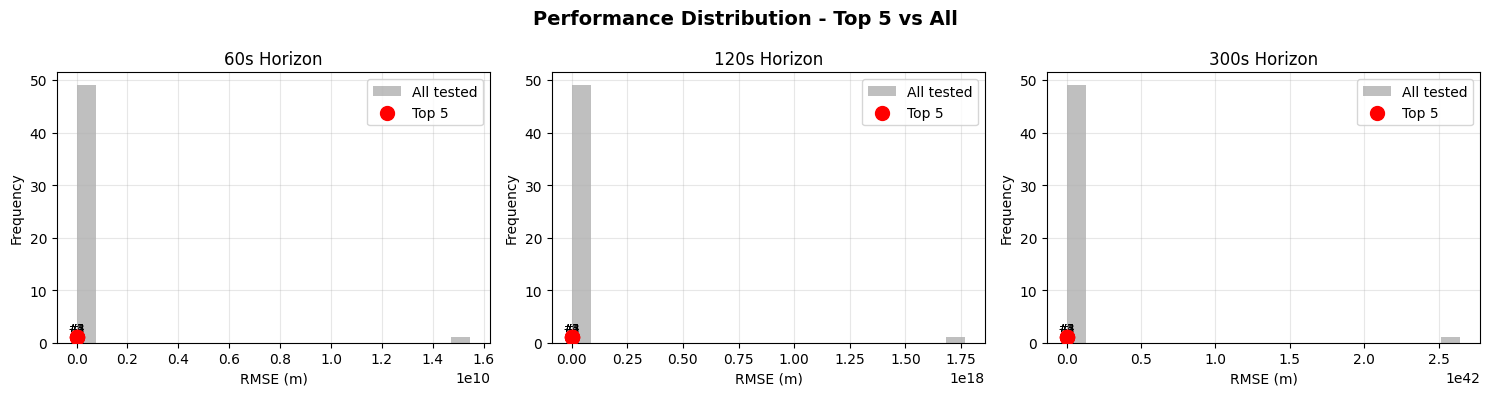

In [23]:
# Select the TOP 5 BEST performing flights
TOP_N = 5
best_flights = perf_df.head(TOP_N).copy()

print("="*60)
print(f"TOP {TOP_N} BEST PERFORMING FLIGHTS")
print("="*60)

for idx, row in best_flights.iterrows():
    print(f"\n{idx+1}. Flight {row['flight_id']}, Run {row['run_id']}")
    print(f"   RMSE: {row['rmse_60']:.1f}m @ 60s, {row['rmse_120']:.1f}m @ 120s, {row['rmse_300']:.1f}m @ 300s")
    print(f"   Points: {row['n_points_original']} original, {row['n_points_resampled']} resampled")
    stats = row['flight_stats']
    print(f"   Distance: {stats['distance']/1000:.1f}km, Alt change: {stats['alt_change']:.0f}m")

# Visualize performance distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, horizon in enumerate([60, 120, 300]):
    ax = axes[idx]
    col = f'rmse_{horizon}'
    
    # All flights
    ax.hist(perf_df[col], bins=20, alpha=0.5, label='All tested', color='gray')
    
    # Top 5
    ax.scatter(best_flights[col], [1]*len(best_flights), 
              color='red', s=100, zorder=5, label='Top 5')
    
    for i, val in enumerate(best_flights[col]):
        ax.annotate(f'#{i+1}', (val, 1), xytext=(0, 5), 
                   textcoords='offset points', ha='center', fontsize=8)
    
    ax.set_xlabel('RMSE (m)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{horizon}s Horizon')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Performance Distribution - Top 5 vs All', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
# Run detailed analysis on the top 5 flights
top5_detailed = {}

print("\nDetailed EKF analysis on Top 5 flights...")
print("-" * 40)

for idx, row in best_flights.iterrows():
    flight_id = row['flight_id']
    run_id = row['run_id']
    
    # Extract and process flight
    flight = df[(df['flight_id'] == flight_id) & (df['run_id'] == run_id)].copy()
    flight = flight.sort_values('time').reset_index(drop=True)
    flight_resampled = resample_track(flight, dt_target=5.0)
    
    # Run EKF
    filtered = ekf.filter_track(flight_resampled)
    
    # Get detailed results
    results = ekf.horizon_errors(flight_resampled, filtered, horizons)
    
    # Store everything
    top5_detailed[f"{flight_id}_{run_id}"] = {
        'flight_id': flight_id,
        'run_id': run_id,
        'original_track': flight,
        'resampled_track': flight_resampled,
        'filtered_track': filtered,
        'horizon_results': results,
        'rmse': rmse_from_results(results),
        'stats': row['flight_stats']
    }
    
    print(f"  Flight {flight_id}: Complete ✓")

print("\n✓ Detailed analysis complete for all Top 5 flights")


Detailed EKF analysis on Top 5 flights...
----------------------------------------
  Flight 4217: Complete ✓
  Flight 5707: Complete ✓
  Flight 5840: Complete ✓
  Flight 6151: Complete ✓
  Flight 5251: Complete ✓

✓ Detailed analysis complete for all Top 5 flights


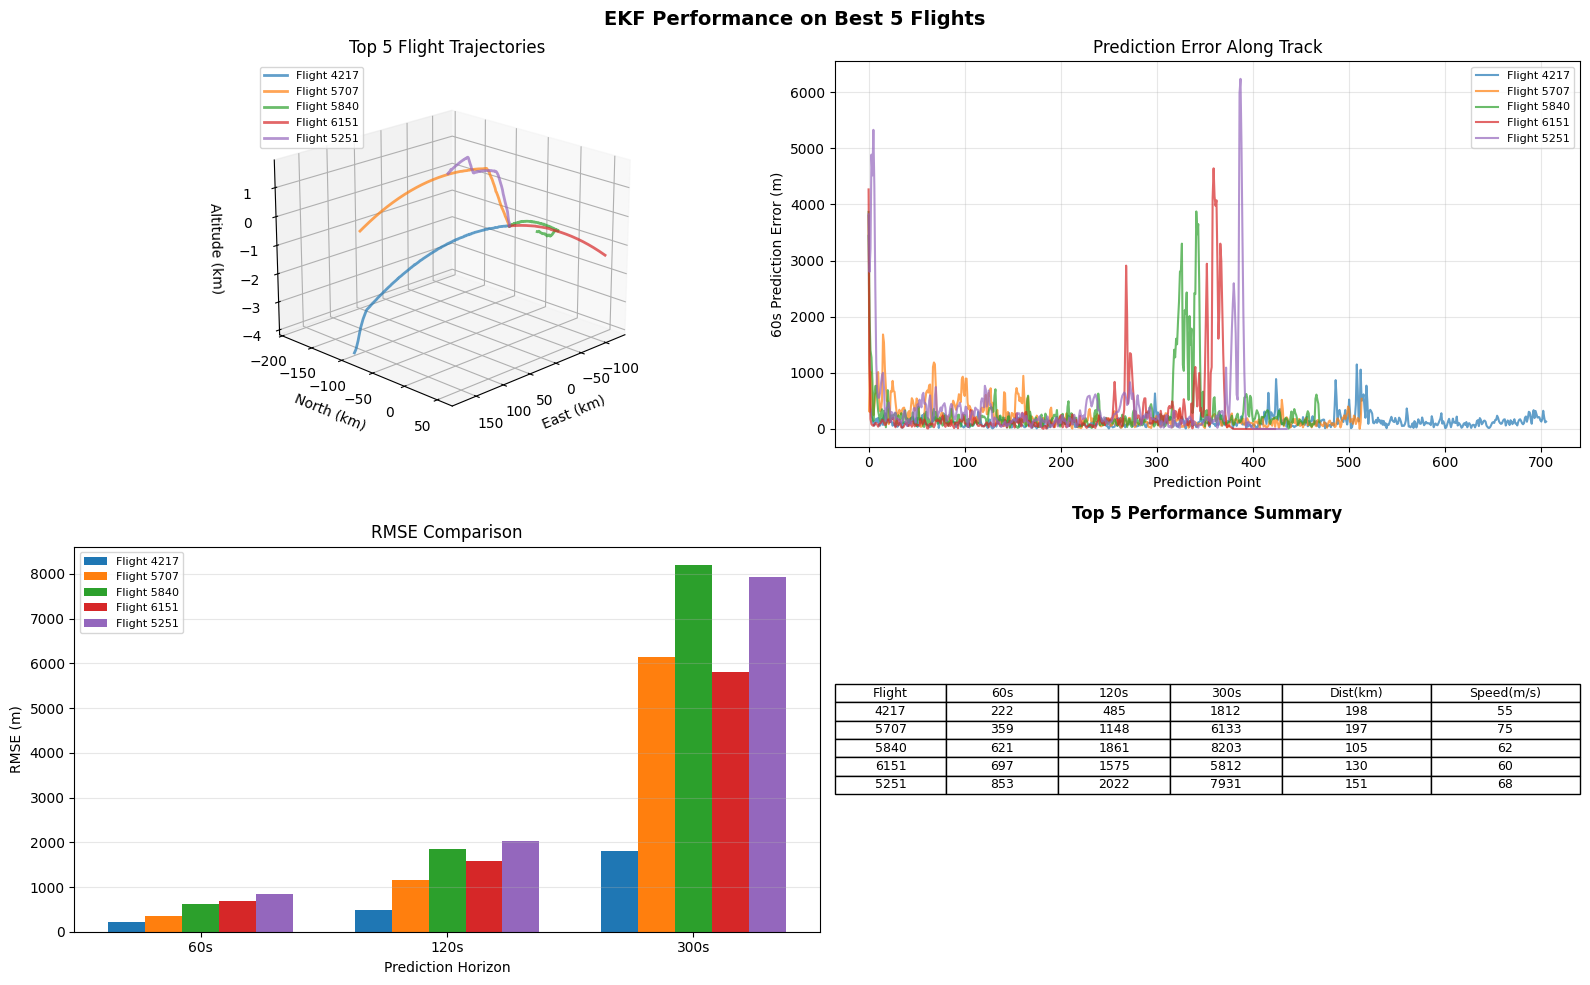

In [25]:
# Create comprehensive visualization of the Top 5
fig = plt.figure(figsize=(16, 10))

# 3D trajectories of all Top 5
ax1 = fig.add_subplot(221, projection='3d')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for idx, (key, data) in enumerate(top5_detailed.items()):
    track = data['resampled_track']
    ax1.plot(track['E']/1000, track['N']/1000, track['U']/1000, 
            color=colors[idx], alpha=0.7, linewidth=2,
            label=f"Flight {data['flight_id']}")

ax1.set_xlabel('East (km)')
ax1.set_ylabel('North (km)')
ax1.set_zlabel('Altitude (km)')
ax1.set_title('Top 5 Flight Trajectories')
ax1.legend(loc='upper left', fontsize=8)
ax1.view_init(elev=20, azim=45)

# Error over prediction time
ax2 = fig.add_subplot(222)
for idx, (key, data) in enumerate(top5_detailed.items()):
    results_60 = data['horizon_results'][60]
    ax2.plot(results_60.index, results_60['err_m'], 
            color=colors[idx], alpha=0.7,
            label=f"Flight {data['flight_id']}")

ax2.set_xlabel('Prediction Point')
ax2.set_ylabel('60s Prediction Error (m)')
ax2.set_title('Prediction Error Along Track')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# RMSE comparison
ax3 = fig.add_subplot(223)
x_pos = np.arange(len(horizons))
width = 0.15

for idx, (key, data) in enumerate(top5_detailed.items()):
    rmse_vals = [data['rmse'][h] for h in horizons]
    ax3.bar(x_pos + idx*width, rmse_vals, width, 
           label=f"Flight {data['flight_id']}", color=colors[idx])

ax3.set_xlabel('Prediction Horizon')
ax3.set_ylabel('RMSE (m)')
ax3.set_title('RMSE Comparison')
ax3.set_xticks(x_pos + width * 2)
ax3.set_xticklabels([f'{h}s' for h in horizons])
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3, axis='y')

# Statistics table
ax4 = fig.add_subplot(224)
ax4.axis('tight')
ax4.axis('off')

table_data = []
for idx, (key, data) in enumerate(top5_detailed.items()):
    table_data.append([
        f"{data['flight_id']}",
        f"{data['rmse'][60]:.0f}",
        f"{data['rmse'][120]:.0f}",
        f"{data['rmse'][300]:.0f}",
        f"{data['stats']['distance']/1000:.0f}",
        f"{data['stats']['mean_speed']:.0f}"
    ])

table = ax4.table(cellText=table_data,
                 colLabels=['Flight', '60s', '120s', '300s', 'Dist(km)', 'Speed(m/s)'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.15, 0.15, 0.15, 0.15, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
ax4.set_title('Top 5 Performance Summary', pad=20, fontweight='bold')

plt.suptitle('EKF Performance on Best 5 Flights', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
# Calculate baseline statistics from ALL tested flights
print("="*60)
print("EKF BASELINE STATISTICS")
print("="*60)

# Remove obvious outliers using IQR method
for col in ['rmse_60', 'rmse_120', 'rmse_300']:
    Q1 = perf_df[col].quantile(0.25)
    Q3 = perf_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    clean_data = perf_df[(perf_df[col] >= lower) & (perf_df[col] <= upper)][col]
    
    horizon = int(col.split('_')[1])
    print(f"\n{horizon}s Horizon:")
    print(f"  Flights tested:    {len(perf_df)}")
    print(f"  After filtering:   {len(clean_data)}")
    print(f"  Mean RMSE:         {clean_data.mean():.1f} m")
    print(f"  Median RMSE:       {clean_data.median():.1f} m")
    print(f"  Std Dev:           {clean_data.std():.1f} m")
    print(f"  90th percentile:   {clean_data.quantile(0.9):.1f} m")

print("\n" + "="*60)
print("TOP 5 AVERAGE (Best Case Performance):")
for h in horizons:
    col = f'rmse_{h}'
    print(f"  {h:3d}s: {best_flights[col].mean():.1f} ± {best_flights[col].std():.1f} m")
print("="*60)

EKF BASELINE STATISTICS

60s Horizon:
  Flights tested:    50
  After filtering:   38
  Mean RMSE:         2079.5 m
  Median RMSE:       1885.5 m
  Std Dev:           1176.7 m
  90th percentile:   3604.5 m

120s Horizon:
  Flights tested:    50
  After filtering:   38
  Mean RMSE:         19144.5 m
  Median RMSE:       4856.0 m
  Std Dev:           69643.7 m
  90th percentile:   7921.6 m

300s Horizon:
  Flights tested:    50
  After filtering:   38
  Mean RMSE:         20820660346.4 m
  Median RMSE:       14319.1 m
  Std Dev:           126478000823.9 m
  90th percentile:   26477.0 m

TOP 5 AVERAGE (Best Case Performance):
   60s: 550.5 ± 255.9 m
  120s: 1418.1 ± 618.1 m
  300s: 5978.4 ± 2557.8 m


In [27]:
# Save all results for use in other notebooks
results_dir = repo_root / "results"
results_dir.mkdir(exist_ok=True)

# Prepare save data
save_data = {
    # Top 5 detailed data
    'top5_detailed': top5_detailed,
    'top5_summary': best_flights.to_dict('records'),
    
    # All performance data
    'all_performance': perf_df.to_dict('records'),
    
    # Statistics
    'baseline_stats': {
        'mean_rmse_60': perf_df['rmse_60'].mean(),
        'median_rmse_60': perf_df['rmse_60'].median(),
        'mean_rmse_120': perf_df['rmse_120'].mean(),
        'median_rmse_120': perf_df['rmse_120'].median(),
        'mean_rmse_300': perf_df['rmse_300'].mean(),
        'median_rmse_300': perf_df['rmse_300'].median(),
    },
    
    # Model parameters
    'ekf_params': EKFParams().__dict__,
    'horizons': horizons,
    
    # Flight IDs for easy access
    'top5_flight_ids': [(row['flight_id'], row['run_id']) for _, row in best_flights.iterrows()]
}

# Save as pickle
save_path = results_dir / "ekf_results_top5.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)

print(f"✓ Results saved to: {save_path}")

# Also save a CSV for easy viewing
best_flights[['flight_id', 'run_id', 'rmse_60', 'rmse_120', 'rmse_300']].to_csv(
    results_dir / "top5_flights.csv", index=False
)

print(f"✓ Top 5 summary saved to: {results_dir / 'top5_flights.csv'}")

print("\n" + "="*60)
print("READY FOR VISUALIZATION IN NOTEBOOK 04!")
print("="*60)
print("\nTop 5 flights saved for comparison:")
for idx, (fid, rid) in enumerate(save_data['top5_flight_ids']):
    rmse_60 = best_flights.iloc[idx]['rmse_60']
    print(f"  {idx+1}. Flight {fid}, Run {rid}: {rmse_60:.1f}m @ 60s")

✓ Results saved to: /Users/danielvillafuerte/weather-aware-trajectory-prediction/results/ekf_results_top5.pkl
✓ Top 5 summary saved to: /Users/danielvillafuerte/weather-aware-trajectory-prediction/results/top5_flights.csv

READY FOR VISUALIZATION IN NOTEBOOK 04!

Top 5 flights saved for comparison:
  1. Flight 4217, Run 0: 222.3m @ 60s
  2. Flight 5707, Run 0: 359.5m @ 60s
  3. Flight 5840, Run 0: 620.8m @ 60s
  4. Flight 6151, Run 0: 697.1m @ 60s
  5. Flight 5251, Run 0: 852.6m @ 60s
